In [6]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

# **Part 0**: Raw Data Overview

In [7]:
# -- |Data details| --
participant_id = '03'
initial_session = 1
n_session = 5

# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_session,initial_session+n_session):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S00{str(i)}/eeg/sub-P0{participant_id}_ses-S00{str(i)}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250,  #OpenBCI Frequency acquistion
        verbose=False
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # # -- |Common Average Reference| --
    # mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

    # # -- |Bandpass filter| --
    # mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(raw_mne, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=False,
        picks = ['C3','Cz','C4','PO7','Pz','PO8']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,154
Events,left: 75right: 79
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\20218094.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=2,fmax=36).plot()
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


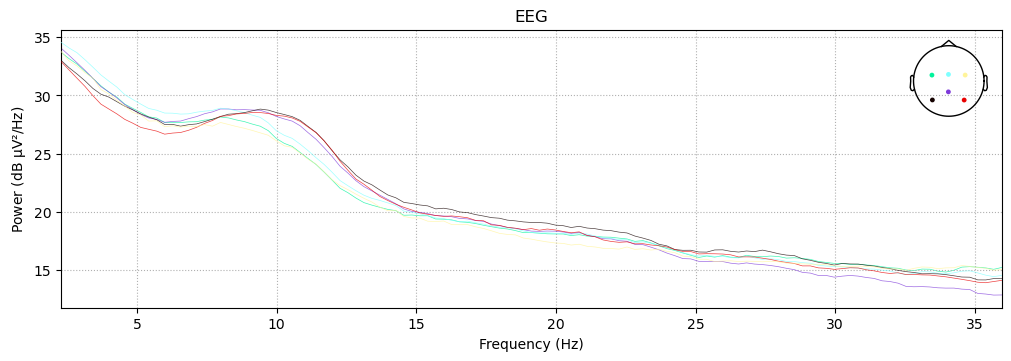

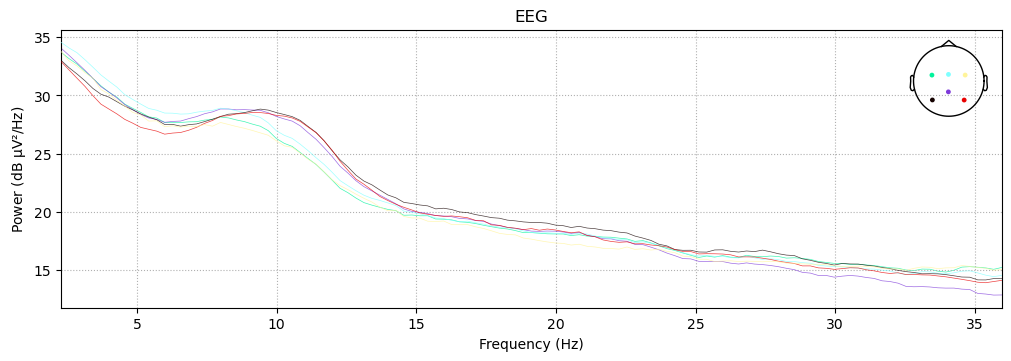

In [8]:
epochs.compute_psd(fmin=2,fmax=36).plot()

# **Part 1**: Without artifact removal

## Preprocessing

In [9]:
# -- |Data details| --
participant_id = '03'
initial_session = 1
n_session = 5

# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_session,initial_session+n_session):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S00{str(i)}/eeg/sub-P0{participant_id}_ses-S00{str(i)}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250,  #OpenBCI Frequency acquistion
        verbose=False
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Common Average Reference| --
    mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

    # -- |Bandpass filter| --
    mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(mne_alpha, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=False,
        picks = ['C3','Cz','C4','PO7','Pz','PO8']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,154
Events,left: 75right: 79
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## ERD Visualization

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\757762342.py:24: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (2.996 s)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


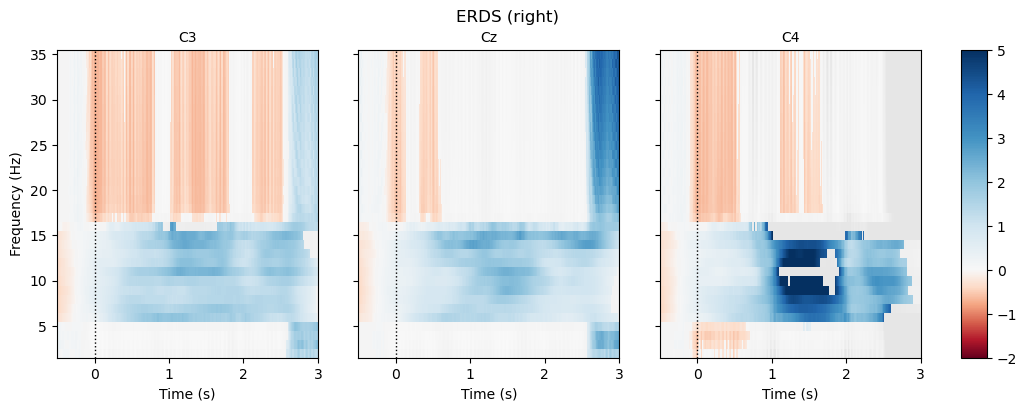

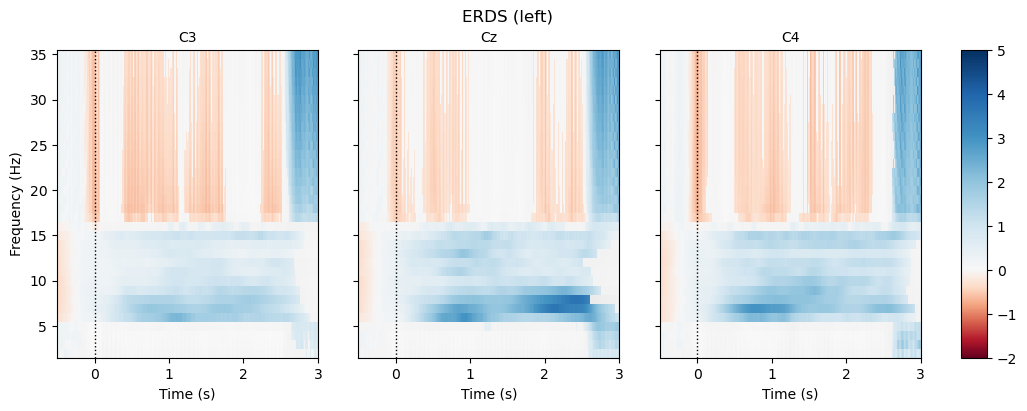

In [10]:
tmin, tmax = -0.5, 3
events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }
freqs = np.arange(2, 36)  # frequencies from 8-12Hz
vmin, vmax = -2, 5  # set min and max ERDS values in plot
baseline = (-0.5, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tfr = epochs.compute_tfr(
    method="multitaper",
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in events_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [11]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4","PO7","Pz","PO8"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 10))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option

## Features Extraction

In [12]:
# Get EEG data and events
X = epochs.get_data(copy=False)
Y = epochs.events[:, -1]

print(f'EEG data shape: {X.shape}')
print(f'events shape  : {Y.shape}')

EEG data shape: (154, 6, 876)
events shape  : (154,)


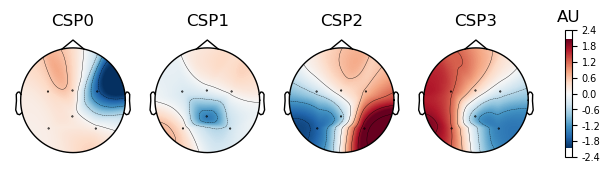

In [44]:
# Initilize CSP
csp = CSP(n_components = 4, norm_trace = False)

# Fit CSP to data 
csp.fit(X,Y)

# Visualize CSP patterns
csp.plot_patterns(epochs.info);

## Classification

In [14]:
# Transform data into CSP space
X_transformed = csp.transform(X)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

Train set shape: (123, 4)
Test set shape : (31, 4)


In [15]:
clf = Pipeline([('SVM', SVC(kernel='linear'))])  
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
accuracy_noArtifactRemoval = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy_noArtifactRemoval}")

report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
print(report)

Accuracy: 0.7419354838709677
              precision    recall  f1-score   support

       right       0.72      0.81      0.76        16
        left       0.77      0.67      0.71        15

    accuracy                           0.74        31
   macro avg       0.75      0.74      0.74        31
weighted avg       0.74      0.74      0.74        31



# **Part 2**: With artifact removal

In [16]:
n_iteration = 3

mne.set_log_level(verbose=False)

K = np.random.rand(4,7)/100    # Initialize hyperparameters

# -- |Channels Information| --
channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250,  #OpenBCI Frequency acquistion
    verbose=False
)

# -- |Events name| --
events_id = { # Set up your event name
    'right': 0,
    'left': 1
}

for j in range(n_iteration):
    accuracy = []
    for k in K: # Generation Iteration
        # -- |Reset Epochs for new hyperparameter| --
        epochs_list = [] 
        for i in range(initial_session,initial_session+n_session): # Offspring Iteration
            # -- |File import| --
            streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S00{str(i)}/eeg/sub-P0{participant_id}_ses-S00{str(i)}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

            # -- |EEG data| --
            EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data

            raw_data = ((EEG["time_series"].T)/1000000)[:-1,:] # Convert microvoltage to voltage
            EOG = ((EEG["time_series"].T)/1000000)[-1,:]

            # -- |Events|--
            Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

            event_index = Events["time_series"].T[0] #Get all event marker of experiment 
            event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

            events = np.column_stack((np.array(event_timestamp, dtype = int),
                                np.zeros(len(event_timestamp), dtype = int),
                                np.array(event_index, dtype = int)))

            # -- |Artifact Removal| --
            raw_data -= np.diag(k)@np.tile(EOG,(7,1))

            # -- |Create MNE rawarray| --
            raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

            # -- |Common Average Reference| --
            mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

            # -- |Bandpass filter| --
            mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

            # -- |Epoch Segmentation| --
            epochs = mne.Epochs(mne_alpha, events, 
                tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
                tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
                event_id =events_id,
                preload = True,
                verbose=False,
                picks = ['C3','Cz','C4','PO7','Pz','PO8']
            )

            epochs_list.append(epochs)

        # -- |Epoch Settings| --
        epochs = mne.concatenate_epochs(epochs_list)
        epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

        # -- |Get EEG data and events| --
        X = epochs.get_data(copy=False)
        Y = epochs.events[:, -1]

        # -- |Initilize CSP| --
        csp = CSP(n_components = 4, norm_trace = False)

        # -- |Fit CSP to data| --
        csp.fit(X,Y)

        # -- |Transform data into CSP space| --
        X_transformed = csp.transform(X)

        # -- |Split data into training and test sets| --
        X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

        # -- |Classification| --
        clf = Pipeline([('SVM', SVC(kernel='linear'))])  
        clf.fit(X_train, Y_train)

        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(Y_test, y_pred))
    
    # -- |Genetic Algorithm| --
    # Parent selection
    parents_ind = np.argpartition(accuracy,-2)[-2:] # select top 2 offspring as new parents
    parents = K[parents_ind]

    offsprings = []
    for offs in range(2):
        offspring = []
        # Breeding
        for m in range(7):
            if np.random.rand() >= 0.5:
                offspring.append(parents[0][m])
            else:
                offspring.append(parents[1][m])
            
        # Mutation
        if np.random.rand() >= 1/(len(parents[0])):
            offspring[np.random.randint(0,len(parents[0]))] += (2*np.random.rand() - 1)/100
        
        offsprings.append(offspring)
    K = np.concatenate((parents, offsprings))

print(K,'\n')
# print(f'Accuracy without artifact removal: {accuracy_noArtifactRemoval}')
print(f'Overall accuracy:\n{accuracy}')
print(f'Output hyperparameters {K[np.argmax(accuracy)]} achieved {np.max(accuracy)} accuracy.')

[[ 0.00635121  0.00605232  0.00594296  0.00372893  0.00147301  0.00256479
   0.00529508]
 [ 0.00251882  0.00605232  0.00594296  0.00479908  0.00370293 -0.00175048
  -0.00218487]
 [ 0.00635121  0.00605232  0.00594296  0.00479908  0.00370293 -0.00175048
   0.00085164]
 [ 0.00251882  0.00605232  0.00594296  0.00372893  0.00370293 -0.00175048
   0.00529508]] 

Overall accuracy:
[0.7419354838709677, 0.7419354838709677, 0.7419354838709677, 0.7419354838709677]
Output hyperparameters [0.00635121 0.00605232 0.00594296 0.00372893 0.00147301 0.00256479
 0.00529508] achieved 0.7419354838709677 accuracy.


# Other Visualizations

In [17]:
right_MI = epochs['right'].average() # Average all right trials
right_MI

Condition,right
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,79
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [18]:
left_MI = epochs['left'].average() # Average all left trials
left_MI

Condition,left
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,75
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [19]:
right_electrodes = ['C4','PO8']
left_electrodes = ['C3','PO7']
center_electrodes = ['Cz']

right_MI_R = epochs['right'].average(picks = right_electrodes)
right_MI_L = epochs['right'].average(picks = left_electrodes)
left_MI_R = epochs['left'].average(picks = right_electrodes)
left_MI_L = epochs['left'].average(picks = left_electrodes)

## Time Domain

### Time Series Plot

#### Right Motor Imagery

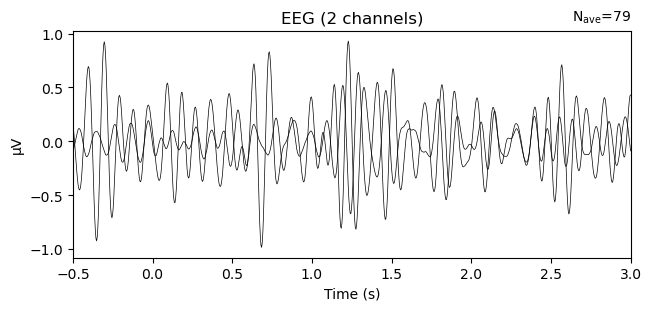

In [20]:
right_MI.plot(picks = right_electrodes, spatial_colors=False);

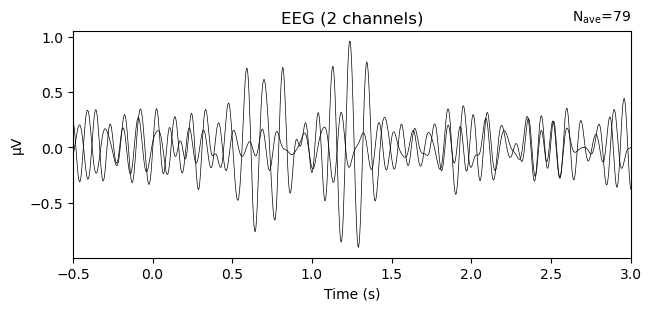

In [21]:
right_MI.plot(picks = left_electrodes, spatial_colors=False);

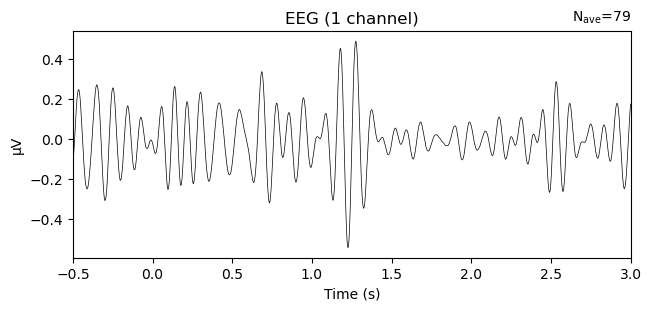

In [22]:
right_MI.plot(picks = center_electrodes, spatial_colors=False);

#### Left Motor Imagery

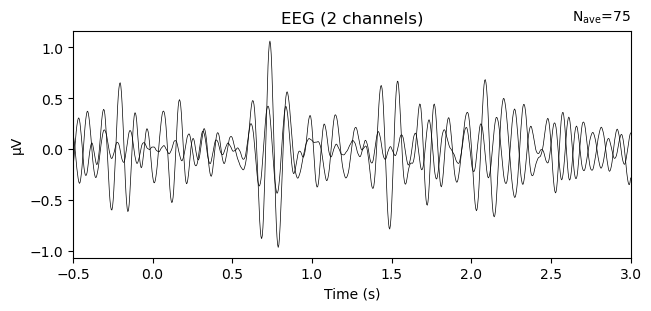

In [23]:
left_MI.plot(picks = right_electrodes, spatial_colors=False);

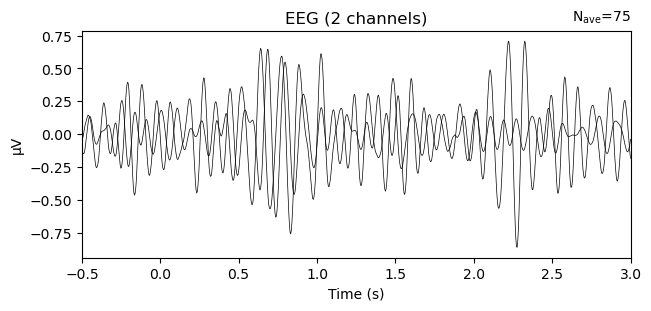

In [24]:
left_MI.plot(picks = left_electrodes, spatial_colors=False);

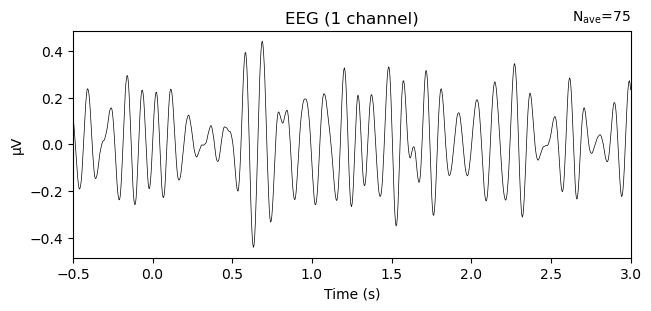

In [25]:
left_MI.plot(picks = center_electrodes, spatial_colors=False);

### Temporal Topology Map

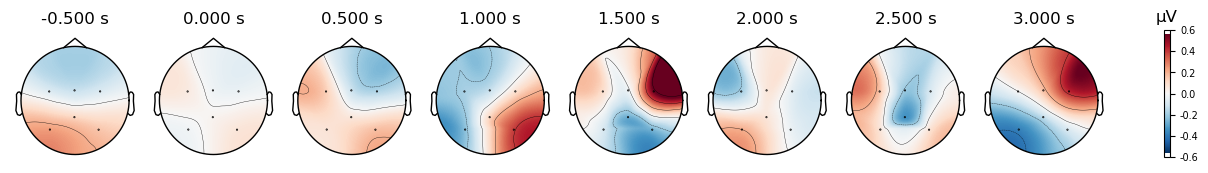

In [26]:
right_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

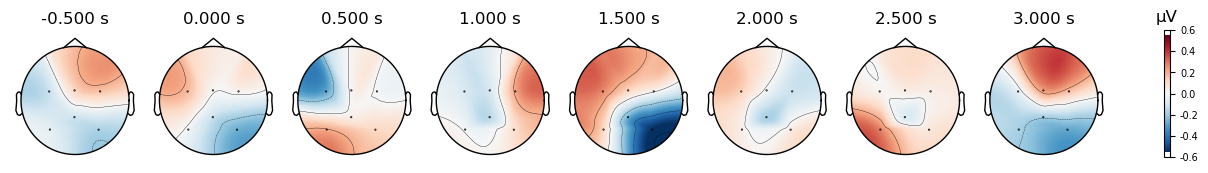

In [27]:
left_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Jointed Plot

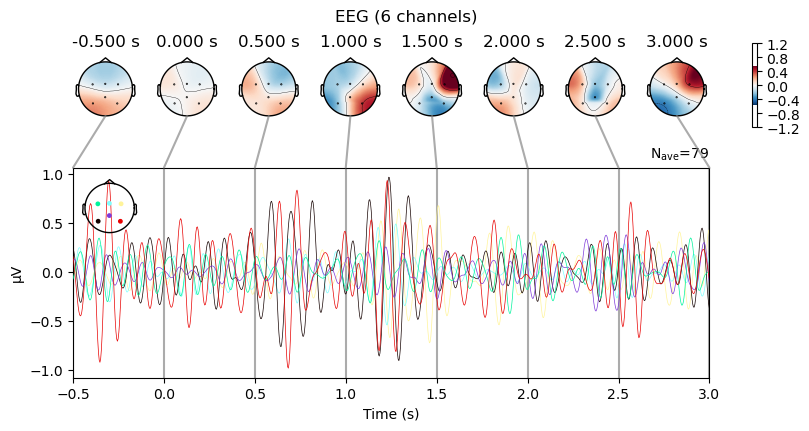

In [28]:
right_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

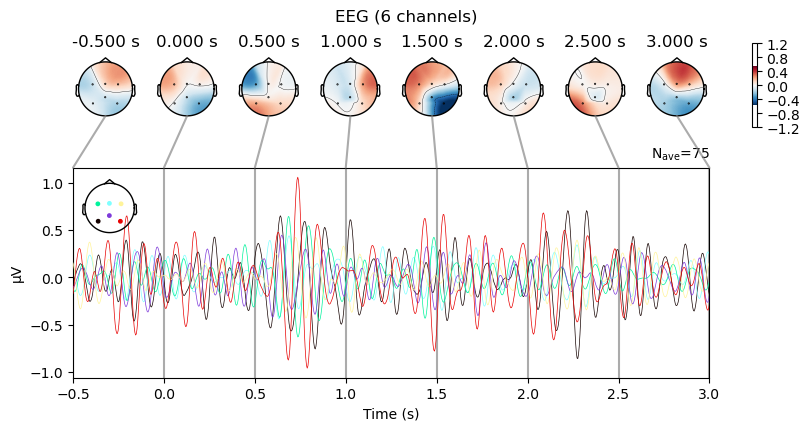

In [29]:
left_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Difference Plot

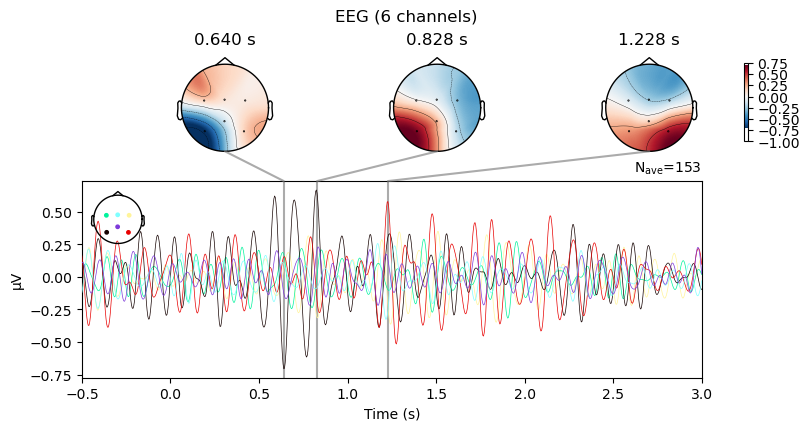

In [30]:
MI_diff = mne.combine_evoked((right_MI,-left_MI), weights='equal')
MI_diff.plot_joint();

## Time-frequency Domain

In [31]:
epochs.compute_psd(fmin = 2, fmax = 60).plot();

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\787761887.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin = 2, fmax = 60).plot();
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


# Temporary Section

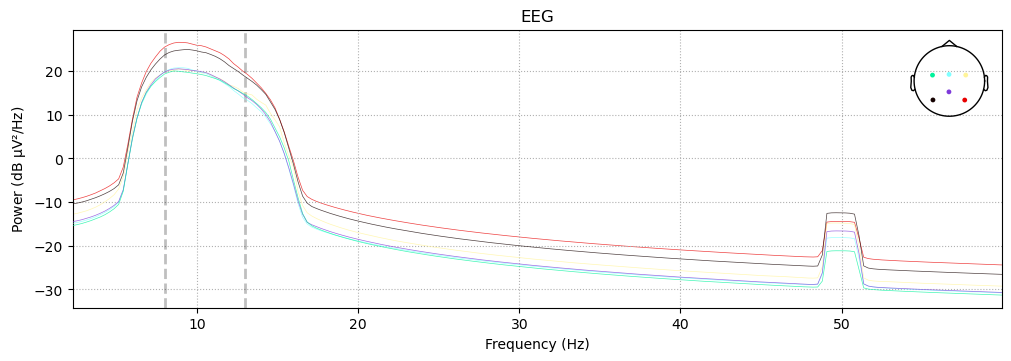

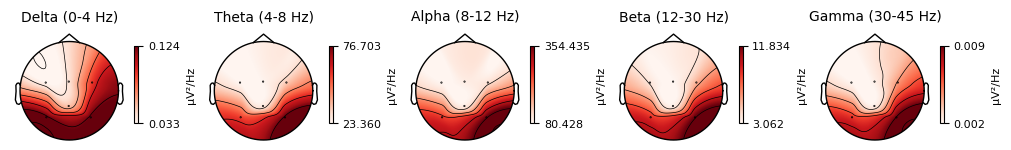

In [32]:
epochs['right'].compute_psd().plot_topomap();

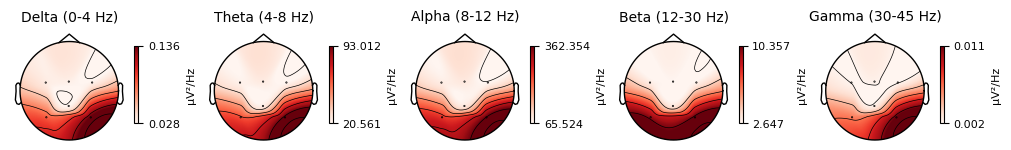

In [33]:
epochs['left'].compute_psd().plot_topomap();

In [34]:
import numpy as np
import scipy


class CSP_ORI:
    def __init__(self, n_components=4):
        self.n_components = n_components

    def fit(self, x, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        if n_classes != 2:
            raise ValueError("n_classes must be 2.")

        covs = []
        for this_class in self.classes:
            x_class = x[y == this_class]
            # Convert data dimention to (channels, epoch * data_point)
            _, n_channels, _ = x_class.shape
            x_class = np.transpose(x_class, [1, 0, 2])
            x_class = x_class.reshape(n_channels, -1)
            cov = np.dot(x_class, x_class.T)
            covs.append(cov)

        # Solve generalized eigenvalue problem
        eig_vals, eig_vecs = scipy.linalg.eigh(covs[0],covs[1])
        for i in range(len(eig_vecs)):
            eig_vecs[i] = eig_vecs[i] / np.linalg.norm(eig_vecs[i])

        i = np.argsort(eig_vals)
        ix = np.empty_like(i)
        ix[1::2] = i[: len(i) // 2]
        ix[0::2] = i[len(i) // 2 :][::-1]

        eig_vecs = eig_vecs[:, ix]
        self.filters = eig_vecs.T
        self.patterns = np.linalg.inv(eig_vecs)
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        self.mean = x.mean(axis=0)
        self.std = x.std(axis=0)

    def transform(self, x):
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        x -= self.mean
        x /= self.std

        return x

    def fit_transform(self, x, y):
        self.fit(x, y)

        return self.transform(x)

In [35]:
csp = CSP_ORI()
csp.fit(X,Y)

In [36]:
def cov(x_class):
    _, n_channels, _ = x_class.shape
    x_class = np.transpose(x_class, [1, 0, 2])
    x_class = x_class.reshape(n_channels, -1) # Concat all trials
    return np.dot(x_class, x_class.T)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [37]:
df = epochs.to_data_frame()
df

,time,condition,epoch,C3,Cz,C4,PO7,Pz,PO8
0,-0.500,left,0,-2.230945,1.402814,1.876774,0.042545,0.341184,-1.335359
1,-0.496,left,0,-2.808088,0.776657,2.093222,0.884698,0.283804,-2.033487
2,-0.492,left,0,-3.145315,0.025161,2.115667,1.735870,0.234302,-2.581132
3,-0.488,left,0,-3.198964,-0.766731,1.928585,2.475803,0.165847,-2.935362
4,-0.484,left,0,-2.951122,-1.519898,1.591055,2.960377,0.041956,-3.096167
...,...,...,...,...,...,...,...,...,...
134899,2.984,right,154,0.149505,-0.409516,-0.801922,0.674263,1.374346,2.488216
134900,2.988,right,154,0.326546,-0.597173,-0.621552,0.668668,0.642031,2.684039
134901,2.992,right,154,0.501128,-0.725079,-0.374478,0.634581,-0.199969,2.610045
134902,2.996,right,154,0.664504,-0.805145,-0.105280,0.590960,-1.083868,2.281221


In [38]:
df.describe()

,time,epoch,C3,Cz,C4,PO7,Pz,PO8
count,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000
mean,1.250000,77.305195,0.002303,0.002006,-0.000289,0.002574,-0.006044,-0.006326
std,1.011521,44.727816,1.378377,1.427531,1.462012,2.377986,1.444169,2.811550
min,-0.500000,0.000000,-11.739290,-10.101174,-42.037445,-14.075221,-9.730308,-18.023429
25%,0.375000,39.000000,-0.858712,-0.881007,-0.807205,-1.427697,-0.881569,-1.614685
50%,1.250000,77.500000,0.003498,0.000899,-0.001967,0.002409,-0.005781,-0.004665
75%,2.125000,116.000000,0.862588,0.888718,0.806282,1.432329,0.868339,1.597728
max,3.000000,154.000000,11.369011,8.984631,49.293621,15.634928,9.818439,18.021177


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\744519546.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\744519546.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


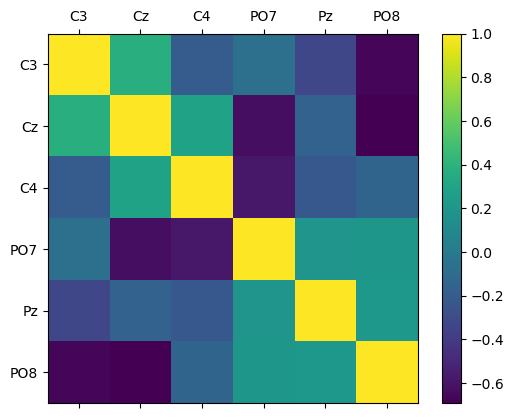

In [39]:
df_numerical = df[epochs.info['ch_names']]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [40]:
x_right = X[Y==0]
np.linalg.eigvals(cov(x_right))

array([7.73472441e-07, 4.12081941e-07, 2.11756422e-08, 4.93081104e-08,
       1.29438403e-07, 1.54322398e-07])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\2090067297.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\2090067297.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


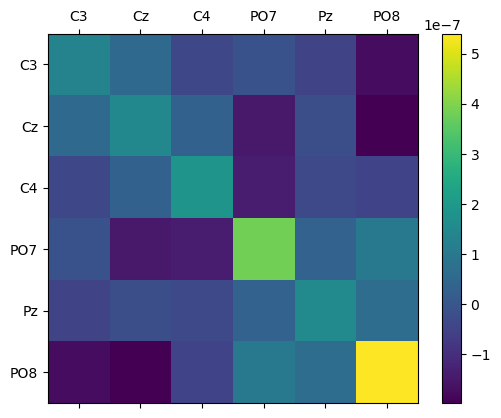

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_right), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [42]:
x_left = X[Y==1]
np.linalg.eigvals(cov(x_left))

array([7.30752051e-07, 4.02717252e-07, 1.29074270e-07, 7.24959902e-08,
       1.77718477e-08, 3.75629541e-08])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\1886860997.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39212\1886860997.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


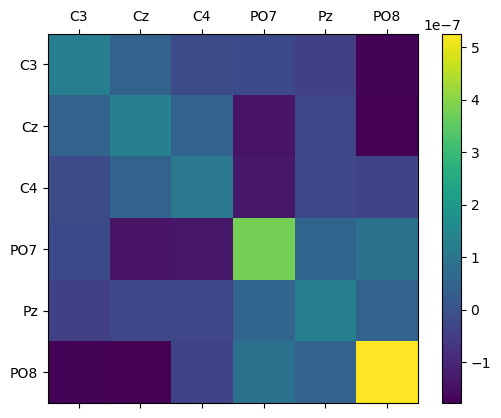

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_left), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()